In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

# Importing Time Series stats stuff
! pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Importing Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

     |████████████████████████████████| 1.1MB 8.6MB/s 


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Follow the instructions in the output after executing this code (go to the URL, authorize, and copy the authorization code)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data (choose 1 - Time Series, Normal)

(Option 1) As a Time Series Dataframe (Only works for one S&P company at a time):

In [4]:
# You need to move the CS3244 Folder from "Shared With Me" into "My Drive"
# df = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/AEP_data.csv', index_col="date", parse_dates=True)
df = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/GOOGL_data_with_news_3.csv', index_col="date", parse_dates=True)
df = df.resample('B').pad()
df.index.freq = 'B'
df.drop('Name', axis=1, inplace=True)
df.head(5)

,open,high,low,close,volume,main_news,tagged_news
date,,,,,,,
2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,Google Changes Its Ad Program to Try to Solve ...,NaN
2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,NaN,NaN
2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,NaN,Q&A: Moving Contacts to a New Phone: You have ...
2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,Lost in Translation? Try a Google App: Google’...,NaN
2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,NaN,NaN


(Option 2) As a normal Dataframe for all companies dataset:

In [0]:
df = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/all_stocks_5yr.csv')
df.drop('date', axis=1, inplace=True)
df.dropna(inplace=True)
df.head()

FileNotFoundError: ignored

In [0]:
def get_summary(df):
    print("Shape: ", df.shape)
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Percentage Missing'] = df.isnull().sum().values / df.shape[0]
    summary['Uniques'] = df.nunique().values
    return summary

get_summary(df)

Shape:  (619029, 6)


,Name,dtypes,Missing,Percentage Missing,Uniques
0,open,float64,0,0.0,49715
1,high,float64,0,0.0,81499
2,low,float64,0,0.0,82354
3,close,float64,0,0.0,51151
4,volume,int64,0,0.0,586434
5,Name,object,0,0.0,505


# Data Visualization (Only for Time Series Dataframe)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


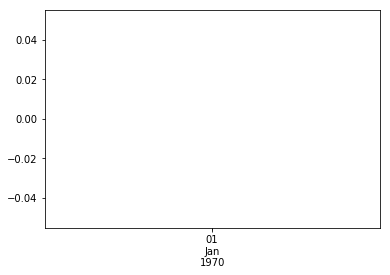

In [0]:
df_ffill = df.iloc[1:]
df_ffill = df_ffill.fillna(method='ffill')
df_ffill['close'].asfreq('B').plot()
plt.show()

In [0]:
df_ffill.loc['2016-05-14':'2016-06-14']['close'].asfreq('B').plot()

TypeError: ignored

In [0]:
result = seasonal_decompose(df.loc['2016-01-01':'2017-01-01']['close'], model='additive')
result.plot();

AttributeError: ignored

# Feature Engineering?

In [0]:
#df['mean_high_low'] = (df['high'] + df['low'])/2
df['amount_traded'] = df['open'] * df['volume']
df.head()

,open,high,low,close,volume,amount_traded,mean_high_low
date,,,,,,,
2013-02-08,44.55,44.63,44.25,44.57,2312792,1.030349e+08,44.44
2013-02-11,44.57,44.74,44.48,44.73,1372326,6.116457e+07,44.61
2013-02-12,44.73,44.94,44.60,44.90,1695150,7.582406e+07,44.77
2013-02-13,44.87,45.04,44.76,44.93,1324472,5.942906e+07,44.90
2013-02-14,44.76,44.81,44.41,44.77,3665271,1.640575e+08,44.61


# Data Preprocessing

(Option 1) For a single S&P company:

In [5]:
df['target_reg'] = df['open'].shift(-1)
df = df.iloc[:-1]
df['target_class'] = df['target_reg'] > df['close']
df.tail(10)

,open,high,low,close,volume,main_news,tagged_news,target_reg,target_class
date,,,,,,,,,
2018-01-24,1184.98,1187.05,1167.40,1171.29,1856429,NaN,NaN,1180.71,True
2018-01-25,1180.71,1185.00,1171.84,1182.14,1499247,NaN,NaN,1187.53,True
2018-01-26,1187.53,1187.56,1168.03,1187.56,2108502,Sharing Events From Other Google Calendars: If...,NaN,1188.00,True
2018-01-29,1188.00,1198.00,1184.06,1186.48,1574708,NaN,NaN,1177.72,False
2018-01-30,1177.72,1187.93,1174.51,1177.37,1866883,NaN,Secrets or Knowledge? Uber-Waymo Trial Tests S...,1183.81,True
2018-01-31,1183.81,1186.32,1172.10,1182.22,1801135,NaN,Tackling the Internet’s Central Villain: The A...,1175.99,False
2018-02-01,1175.99,1187.45,1169.36,1181.59,3675709,NaN,NaN,1127.42,False
2018-02-02,1127.42,1131.30,1111.17,1119.20,5892122,Alphabet’s Earnings Disappoint. Blame It on th...,NaN,1100.61,False
2018-02-05,1100.61,1114.99,1056.74,1062.39,4177469,NaN,NaN,1033.98,False


In [0]:
df_copy = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/AEP_data.csv', index_col="date", parse_dates=True)
df_copy = df_copy.resample('B').pad()
df_copy.index.freq = 'B'
df_copy.drop('Name', axis=1, inplace=True)
df_copy.head(5)

# variables for predicting whether opening price increases or decreases
df_copy['new_variable'] = ((df_copy['high'] - df_copy['open']) + (df_copy['low'] - df_copy['open']));
df_copy['relative_closing'] = (df_copy['close'] - df_copy['open']);
df_copy['target_reg'] = df_copy['open'].shift(-1)
df_copy['target_class_2'] = (df_copy['target_reg'] > df_copy['open']); # compare with previous day opening price
df_copy['relative_target'] = (df_copy['target_reg'] - df_copy['open']);

# variables for predicting whether closing price increases or decreases
'''df_copy['relative_high'] = ((df_copy['high'] - df_copy['close']));
df_copy['relative_low'] = ((df_copy['low'] - df_copy['close']));
df_copy['relative_high^2'] = ((df_copy['high'] - df_copy['close'])*(df_copy['high'] - df_copy['close']));
df_copy['relative_low^2'] = ((df_copy['low'] - df_copy['close'])*(df_copy['low'] - df_copy['close']));
df_copy['target_reg'] = df_copy['close'].shift(-1)
df_copy['target_class_2'] = (df_copy['target_reg'] > df_copy['close']); # compare with previous day closing price
df_copy['relative_target'] = (df_copy['target_reg'] - df_copy['close']);'''

df_copy.drop('high',axis = 1,inplace = True);
df_copy.drop('low', axis = 1,inplace = True);
df_copy.drop('close',axis = 1,inplace = True);
df_copy.drop('volume',axis = 1,inplace = True);
df_copy = df_copy.iloc[:-1]
# print(df_copy.tail(10));

''' (target_reg - open) = theta_1*((high - open)+(low - open)) + theta_2*(close - open)
    theta_0 = 0
    target_reg - open > 0 is price increase
    target_reg - open < 0 is price decrease '''

df_X = df_copy.drop(['target_reg','target_class_2','relative_target','open'],axis = 1);
df_Y = df_copy['relative_target'];

# print(df_X.tail(5));
# print(df_Y.tail(5));

X = df_X.to_numpy();
Y = df_Y.to_numpy();
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, shuffle=False);

# print(X[len(X)-2])
# print(Y[len(Y)-2])

'''print(len(X));
print(len(Y));
print(len(X_train));
print(len(Y_train));
print(len(X_test));
print(len(Y_test));'''

''' attempting perceptron learning algorithm linear and logistic regression similar to week 4 lecture topic'''

weights = np.zeros(X[0].shape, np.float)
# print(weights)

def prediction_linear(weights,X,Y):
    predictions = np.zeros(Y.shape, np.float);
    i = 0;
    while (i < len(X)):
        predictions[i] = np.dot(weights,X[i]);
        i = i + 1;
        
    return predictions;

alpha = 0.3;
#J_train = (1/len(Y_train))*np.dot(np.ones(Y_train.shape,np.float),np.square(prediction_linear(weights,X_train,Y_train)-Y_train));
#print(J_train);
''' (1//size of training data)*(sum of (theta_transpose*X[i] - Y[i])^2)'''
def gradient_J_train_linear(U,V,weights):
    i = 0;
    gradient = np.zeros(weights.shape, np.float);
    errors = prediction_linear(weights,U,V)-V;
    while (i < len(V)):
        gradient = U[i]*errors[i];
        i = i + 1;
    
    return (2/len(V))*gradient;

def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z));

def prediction_logistic(weights,X,Y):
    predictions = np.zeros(Y.shape, np.float);
    i = 0;
    while (i < len(X)):
        z = np.dot(weights,X[i]);
        predictions[i] = sigmoid(z);
        i = i + 1;
        
    return predictions;
  
def gradient_J_train_logistic(U,V,weights):
    i = 0;
    gradient = np.zeros(weights.shape, np.float);
    while (i < len(V)):
        gradient = gradient + (V[i]/(1 + np.exp(V[i]*np.dot(weights,U[i]))))*U[i];
        i = i + 1;
    return (1/len(V))*gradient;

k = 0

#Linear

while (k < 10000):
    weights = weights - alpha*gradient_J_train_linear(X_train,Y_train,weights);
    k = k + 1;

J_train = (1/len(Y_train))*np.dot(np.ones(Y_train.shape,np.float),np.square(prediction_linear(weights,X_train,Y_train)-Y_train));
print(J_train);
print(weights);
X_train_predictions = prediction_linear(weights,X_train,Y_train);
X_test_predictions = prediction_linear(weights,X_test,Y_test);

count = 0;
k = 0
while (k < len(X_train)):
    if (((Y_train[k] >= 0) and (X_train_predictions[k] >= 0)) or ((Y_train[k] < 0) and (X_train_predictions[k] < 0))):
        count = count + 1;
    k = k + 1;

print(count/len(X_train)); # correct classification of training data

count = 0;
k = 0;
while (k < len(X_test)):
    if (((Y_test[k] >= 0) and (X_test_predictions[k] >= 0)) or ((Y_test[k] < 0) and (X_test_predictions[k] < 0))):
        count = count + 1;
    k = k + 1;

print(count/len(X_test));

#Logistic

'''while (k < 10000):
    weights = weights - alpha*gradient_J_train_logistic(X_train,Y_train,weights);
    k = k + 1;

#J_train = (1/len(Y_train))*np.dot(np.ones(Y_train.shape,np.float),np.square(prediction_linear(weights,X_train,Y_train)-Y_train));
#print(J_train);
print(weights);
X_train_predictions = prediction_logistic(weights,X_train,Y_train);
X_test_predictions = prediction_logistic(weights,X_test,Y_test);

count = 0;
k = 0
while (k < len(X_train)):
    if (((Y_train[k] >= 0) and (X_train_predictions[k] >= 0)) or ((Y_train[k] < 0) and (X_train_predictions[k] < 0))):
        count = count + 1;
    k = k + 1;

print(count/len(X_train)); # correct classification of training data

count = 0;
k = 0;
while (k < len(X_test)):
    if (((Y_test[k] >= 0) and (X_test_predictions[k] >= 0)) or ((Y_test[k] < 0) and (X_test_predictions[k] < 0))):
        count = count + 1;
    k = k + 1;

print(count/len(X_test));'''

# print(gradient_J_train_linear(X,Y,weights));
''' (2/size of training data)*(sum of (X[i]_transpose)*(theta_transpose*X[i] - Y[i]))'''


# Opening price

# results for predicting opening price using linear regression.
# (target_reg - open) = theta_1*((high - open)+(low - open)) + theta_2*(close - open)

# target_reg - open > 0 is price increase
# target_reg - open < 0 is price decrease

# 84.9% correct on training for AEP stock using 20% as test data
# 85.0% correct on testing for AEP stock
# weights = [0.47188229 0.54840374]

# 85.3% correct on training for AEP stock using 50% as test data
# 84.5% correct on testing for AEP stock
# weights = [0.52950128 0.58623356]

# 85.1% correct on training for AEE stock using 20% as test data
# 83.5% correct on testing for AEE stock
# weights = [0.18351934 0.17554023]

# 85.4% correct on training for AEE stock using 50% as test data
# 84.8% correct on testing for AEE stock
# weights = [0.50775621 0.55006923]

# results for predicting opening price using logistic regression.

# 56.5% correct on training for AEP stock using 20% as test data
# 51.7% correct on testing for AEP stock
# weights = [-872.13419994 -837.19980717]

# 55.0% correct on training for AEP stock using 50% as test data
# 56.1% correct on testing for AEP stock
# weights = [-731.05319036 -687.89309129]

# 57.3% correct on training for AEE stock using 20% as test data
# 52.9% correct on testing for AEE stock
# weights = [-554.38697336 -544.63973153]

# 56.2% correct on training for AEE stock using 50% as test data
# 56.6% correct on testing for AEE stock
# weights = [-461.59725938 -444.28220256]


# Closing Price

# results for predicting closing price using linear regression
# (target_reg - close) = theta_1*(high - close) + theta_2*(low - close) + theta_3*(high - close)^2 + theta_4*(low - close)^2

# target_reg - close > 0 is price increase
# target_reg - close < 0 is price decrease

# 56.3% correct on training for AEP stock using 20% as test data
# 54.4% correct on testing for AEP stock
# weights = [ 0.13402628 -0.02271632  0.0790755   0.00227163]

# 44.4% correct on training for AEP stock using 50% as test data
# 43.7% correct on testing for AEP stock
# weights = [-0.00909077  0.02903181 -0.00281814 -0.0287415]

# 56.3% correct on training for AEE stock using 20% as test data
# 53.6% correct on testing for AEE stock
# weights = [ 0.05318701 -0.01934073  0.01755171  0.00232089]

# 45.0% correct on training for AEE stock using 50% as test data
# 43.4% correct on testing for AEE stock
# weights = [-0.06359896  0.23319618 -0.01335578 -0.17956106]

# results for predicting closing price using logistic regression

# 56.3% correct on training for AEP stock using 20% as test data
# 54.4% correct on testing for AEP stock
# weights = [-94.17108818 -250.94420008 -150.36207644  247.57131529]

# 55.6% correct on training for AEP stock using 50% as test data
# 56.3% correct on testing for AEP stock
# weights = [-266.77593676  231.7365324  -193.75017805 -134.7639051]

# 56.3% correct on training for AEE stock using 20% as test data
# 53.6% correct on testing for AEE stock
# weights = [-185.4425766   206.81398747 -126.66382122 -131.1360525]

# 55.0% correct on training for AEE stock using 50% as test data
# 56.6% correct on testing for AEE stock
# weights = [-155.88806094  152.95219604  -98.73466738  -77.86728846]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: overflow encountered in exp


[-731.05319036 -687.89309129]
0.5499231950844854
0.5613496932515337


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in exp


' (2/size of training data)*(sum of (X[i]_transpose)*(theta_transpose*X[i] - Y[i]))'

(Option 2) For all companies dataset:

In [0]:
df[['target_reg', 'Name2']] = df[['open', 'Name']].shift(-1)
df = df[df['Name'] == df['Name2']]
df['target_class'] = df['target_reg'] > df['close']
df.drop('Name2', inplace=True, axis=1)
df = pd.get_dummies(df, drop_first=True)
df.tail()

,open,high,low,close,volume,target_reg,target_class,Name_AAL,Name_AAP,Name_AAPL,Name_ABBV,Name_ABC,Name_ABT,Name_ACN,Name_ADBE,Name_ADI,Name_ADM,Name_ADP,Name_ADS,Name_ADSK,Name_AEE,Name_AEP,Name_AES,Name_AET,Name_AFL,Name_AGN,Name_AIG,Name_AIV,Name_AIZ,Name_AJG,Name_AKAM,Name_ALB,Name_ALGN,Name_ALK,Name_ALL,Name_ALLE,Name_ALXN,Name_AMAT,Name_AMD,Name_AME,...,Name_UTX,Name_V,Name_VAR,Name_VFC,Name_VIAB,Name_VLO,Name_VMC,Name_VNO,Name_VRSK,Name_VRSN,Name_VRTX,Name_VTR,Name_VZ,Name_WAT,Name_WBA,Name_WDC,Name_WEC,Name_WFC,Name_WHR,Name_WLTW,Name_WM,Name_WMB,Name_WMT,Name_WRK,Name_WU,Name_WY,Name_WYN,Name_WYNN,Name_XEC,Name_XEL,Name_XL,Name_XLNX,Name_XOM,Name_XRAY,Name_XRX,Name_XYL,Name_YUM,Name_ZBH,Name_ZION,Name_ZTS
619034,78.49,78.77,76.54,76.73,4136360,76.84,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
619035,76.84,78.27,76.69,77.82,2982259,77.53,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
619036,77.53,78.12,76.73,76.78,2595187,76.64,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
619037,76.64,76.92,73.18,73.83,2962031,72.74,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
619038,72.74,74.56,72.13,73.27,4924323,72.70,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Utility Functions

In [0]:
def classification_score(y_test, y_pred):
  y_test = pd.DataFrame(y_test, columns=['target_class'])
  y_pred = pd.DataFrame(y_pred, columns=['pred_class'])
  y_test = y_test.reset_index()
  y_test = pd.concat([y_test, y_pred], axis=1)
  score = y_test['target_class'] == y_test['pred_class']
  score = score.astype(int)
  score = score.sum() / score.shape[0]
  print("Test score: ", score)

# KNN Regressor
Using pure Regression and not Time Series. Structured the problem as the regression problem

In [0]:
from sklearn.neighbors import KNeighborsRegressor
y = df['target_reg']
x = df.drop(['target_class', 'target_reg'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle=False)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
regressor.score(x_test, y_test)

0.4482336244947792

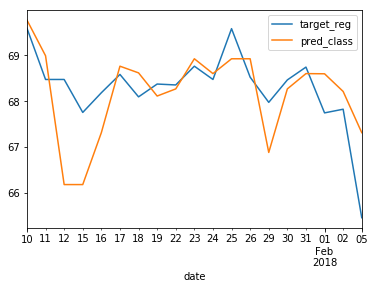

In [0]:
y_test = pd.DataFrame(y_test, columns=['target_reg'])
y_pred = pd.DataFrame(y_pred, columns=['pred_class'])
y_test = y_test.reset_index()
y_test = pd.concat([y_test, y_pred], axis=1)
y_test = y_test.iloc[:-1]
y_test['date'] = pd.to_datetime(y_test['date'])
y_test.set_index('date', inplace=True)
y_test.sort_index(inplace=True)
y_test.loc['2018-01-10':].plot()

# KNN Classifier
Classifying whether the opening stock price on the next day increases or decreases. \\
0.64 accuracy, 0.050 std - using K-fold cross validation

In [0]:
from sklearn.neighbors import KNeighborsClassifier
y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
classifier.score(x_test, y_test)

0.5440613026819924

In [0]:
classification_score(y_test, y_pred)

Test score:  0.5287356321839081


# Random Forest Classifier

0.76 accuracy, 0.052 std  - using K-fold cross validation, better than KNN. Random Forest Classifier's score function is weird.

In [0]:
from sklearn.ensemble import RandomForestClassifier

# limit = 100000 # limit samples
y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = RandomForestClassifier(n_estimators=10, criterion='entropy')
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(classifier.score(x_test, y_test))
cm = confusion_matrix(y_test, y_pred)
cm

0.5287356321839081


array([[80, 51],
       [72, 58]])

In [0]:
classification_score(y_test, y_pred)

Test score:  0.5235


# AdaBoost

0.59 accuracy, 0.048 std - using K-fold cross validation.

In [0]:
from sklearn.ensemble import AdaBoostClassifier
y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
a
classifier = AdaBoostClassifier()
classifier.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

# XGBoost

0.73 accuracy, 0.036 std - using K-fold cross validation.

In [0]:
from xgboost import XGBClassifier
y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = XGBClassifier()
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# K-Fold Cross Validation

In [0]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
# accuracies = cross_val_score(estimator = classifier, X = scaled_x_train, y = y_train, cv = 10)
print("Mean: ", accuracies.mean())
print("Std: ", accuracies.std())

Mean:  0.5211742949607027
Std:  0.04684812405042599


# Simple Neural Network for Classification

In [0]:
from keras import optimizers

y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)
model = Sequential()
model.add(Dense(5, input_dim=5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(x, y, epochs=100, batch_size=10)
_, accuracy = model.evaluate(x, y)
print('Accuracy: %.2f' % (accuracy*100))

# Time Series Exploration

Using Regression instead of Classification

In [7]:
# Test Train split
num_observations = 20
train, test = df[0:-num_observations], df[-num_observations:]
train = train.drop(['main_news', 'tagged_news'], axis = 1)
test = test.drop(['main_news', 'tagged_news'], axis = 1)
train.tail(10)

,open,high,low,close,volume,target_reg,target_class
date,,,,,,,
2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,1062.25,True
2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,1055.49,False
2017-12-29,1055.49,1058.05,1052.70,1053.40,1180340,1055.49,True
2018-01-01,1055.49,1058.05,1052.70,1053.40,1180340,1053.02,False
2018-01-02,1053.02,1075.98,1053.02,1073.21,1588268,1073.93,True
2018-01-03,1073.93,1096.10,1073.43,1091.52,1565945,1097.09,True
2018-01-04,1097.09,1104.08,1094.26,1095.76,1302569,1103.45,True
2018-01-05,1103.45,1113.58,1101.80,1110.29,1512526,1111.00,True
2018-01-08,1111.00,1119.16,1110.00,1114.21,1232221,1118.44,True


In [0]:
# Test if dataset is stationary
def adf_test(series, title=''):
  print(f'Augmented Dickey-Fuller Test: {title}')
  result = adfuller(series.dropna(), autolag='AIC')
  labels = ['ADF Test Statistic', 'p-value', '# lags used', '# observations']
  out = pd.Series(result[0:4], index=labels)
  return out
adf_test(df['target_reg'].diff())

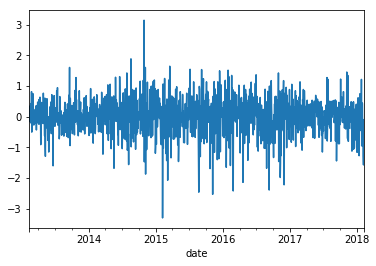

In [0]:
df['target_reg'].diff().plot()

# AUTO ARIMA
Only uses training data.

In [0]:
# Training Models (ARIMA?)
model = auto_arima(train['target_reg'], start_p=0, start_q=0,max_p=3, max_q=3, m=52, seasonal=True, d=1, trace=True, error_action='ignore',suppress_warnings=True)
model.fit(train['target_reg'])
ARIMA_forecast = model.predict(n_periods=num_observations)
ARIMA_forecast = pd.DataFrame(ARIMA_forecast,index = test.index,columns=['target_reg'])

KeyError: ignored

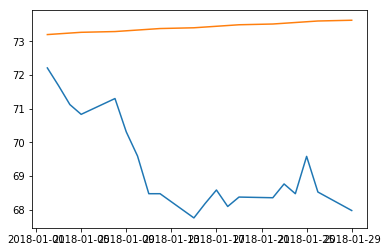

In [0]:
# plt.plot(train['target_reg'])
plt.plot(test['target_reg'])
plt.plot(ARIMA_forecast['target_reg'])

# ARIMA
Rebuild model and append test observation to training data before repredicting the next test data point.

In [0]:
history = [x for x in train['target_reg']]
predictions = list()
for t in range(len(test)):
  model = ARIMA(history, order=(1, 1, 0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test['target_reg'].iloc[t]
  history.append(obs)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


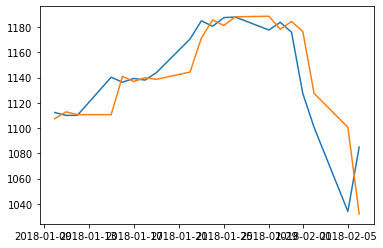

In [9]:
# plt.plot(train.loc['2017-07-01':]['target_reg'])
plt.plot(test['target_reg'])
plt.plot(test.index, predictions)

# SARIMAX
Only uses training data + exog variables from test data ('open', 'high', 'low', 'close', 'volume')

In [0]:
model = SARIMAX(train['target_reg'], exog=train[['open', 'high', 'low', 'close', 'volume']], order=(0, 1, 0))
results = model.fit()
start=len(train)
end=len(train) + len(test) - 1
SARIMAX_forecast = results.predict(start=start, end=end, dynamic=False, typ='levels', exog=test[['open', 'high', 'low', 'close', 'volume']]).rename("pred_reg")
train.tail()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,open,high,low,close,volume,main_news,tagged_news,target_reg,target_class
date,,,,,,,,,
2018-01-03,1073.93,1096.10,1073.43,1091.52,1565945,NaN,Researchers Discover Two Major Flaws in the Wo...,1097.09,True
2018-01-04,1097.09,1104.08,1094.26,1095.76,1302569,NaN,What You Need to Do Because of Flaws in Comput...,1103.45,True
2018-01-05,1103.45,1113.58,1101.80,1110.29,1512526,Sharing Online Albums With Google Photos: Even...,NaN,1111.00,True
2018-01-08,1111.00,1119.16,1110.00,1114.21,1232221,"Google Memo Author Sues, Claiming Bias Against...",NaN,1118.44,True
2018-01-09,1118.44,1118.44,1108.20,1112.79,1340381,NaN,Kodak to Issue Its Own Virtual Currency: DealB...,1107.00,False


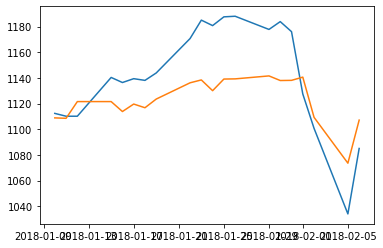

In [0]:
# plt.plot(train.loc['2017-09-01':]['target_reg'])
plt.plot(test['target_reg'])
plt.plot(SARIMAX_forecast)
# SARIMAX_forecast
test_combined = pd.concat([test, SARIMAX_forecast], axis=1)
test_combined['pred_class'] = test_combined['pred_reg'] > test_combined['close']
score = test_combined['target_class'] == test_combined['pred_class']
score = score.astype(int)
score = score.sum() / score.shape[0]
print("Test score: ", score)

In [0]:
# Evaluate Model
RMSE = rmse(test['target_reg'], forecast['target_reg'])
MSE = mse(test['target_reg'], forecast['target_reg'])
MAE = meanabs(test['target_reg'], forecast['target_reg'])
print(f'Model RMSE: {RMSE:.3f}')
print(f'Model MSE: {MSE:.3f}')
print(f'Model MAE: {MAE:.3f}')

# Keras

Using only the past closing data

In [0]:
train_2 = train['target_reg'].to_frame()
test_2 = test['target_reg'].to_frame()
scaler = MinMaxScaler()
scaler.fit(train_2)
scaled_train = scaler.transform(train_2)
scaled_test = scaler.transform(test_2)
n_input = num_observations
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [11]:
X, y = generator[0]
print(f'Input: \n{X.flatten()}')
print(f'Predict: \n{y}')

Input: 
[0.00630505 0.00859102 0.0074856  0.00721265 0.01244636 0.01244636
 0.01830791 0.02466081 0.01967946 0.0205392  0.02261371 0.01763236
 0.01749588 0.02179487 0.01954299 0.02466081 0.04078514 0.04903832
 0.0442856  0.04458595]
Predict: 
[[0.04266837]]


In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=1)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





1263/1263 [==============================] - 34s 27ms/step - loss: 0.0033


In [13]:
scaled_test[0]

array([0.99164253])

In [0]:
scaled_train[-num_observations:]
first_eval_batch = scaled_train[-num_observations:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

test_predictions = []
first_eval_batch = scaled_train[-num_observations:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
np.append(current_batch[:, 1:, :], [[[99]]], axis=1)

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[scaled_test[i]]], axis=1)
  
true_predictions = scaler.inverse_transform(test_predictions)
test['predictions'] = true_predictions

,open,high,low,close,volume,target_reg,target_class,predictions
date,,,,,,,,
2018-01-10,1107.00,1112.78,1103.98,1110.14,1036655,1112.31,True,1089.400921
2018-01-11,1112.31,1114.85,1106.48,1112.05,1121216,1110.10,False,1093.883864
2018-01-12,1110.10,1131.30,1108.01,1130.65,1929306,1110.10,False,1097.831167
2018-01-15,1110.10,1131.30,1108.01,1130.65,1929306,1140.31,True,1101.212228
2018-01-16,1140.31,1148.88,1126.66,1130.70,1823100,1136.36,True,1105.775832


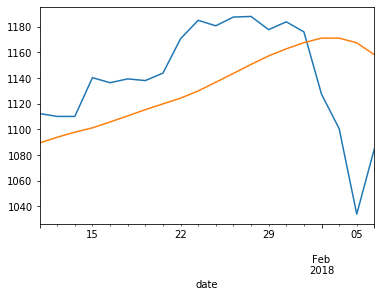

In [16]:
# train.loc['2018-01-01':]['target_reg'].plot()
test['target_reg'].plot()
test['predictions'].plot()
test.head()

# Keras 2

Testing to use all 5 features ('open', 'high', 'low', 'close', 'volume') as input to the Neural Network

In [0]:
# Test Train split
num_observations = 20 # length of test data
train, test = df[0:-num_observations][['open', 'high', 'low', 'close', 'volume']], df[-num_observations:][['open', 'high', 'low', 'close', 'volume']]
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
n_input = 2 # how many days to look back
n_features = 5 # number of features
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1) # look back up to 20 observations ago

In [18]:
X, y = generator[0]
print(f'Input: \n{X.flatten()}')
print(f'Predict: \n{y}')

Input: 
[0.0074856  0.00488824 0.01256411 0.01332344 0.24354676 0.00630505
 0.0023686  0.00857516 0.01130324 0.16838761]
Predict: 
[[0.00859102 0.00573282 0.01243365 0.01012533 0.14113342]]


In [19]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(50))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=1)

Epoch 1/1
1281/1281 [==============================] - 10s 8ms/step - loss: 0.0061


In [0]:
batch = scaled_train[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

# current_batch = np.append(current_batch[:, 1:, :], [[[99, 99, 99, 99, 99]]], axis=1)
test_predictions = list()
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[scaled_test[i]]], axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
true_predictions = pd.DataFrame(true_predictions, columns=['open', 'high', 'low', 'close', 'volume'])
test['pred_reg'] = np.nan
for i in range(len(test)):
  test.iat[i, 5] = true_predictions.iloc[i]['open']

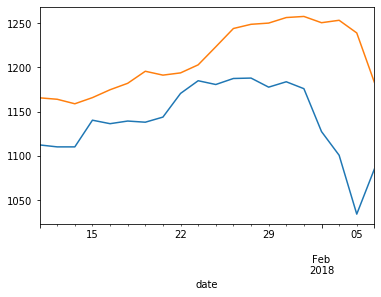

In [21]:
# train.loc['2018-01-14':]['close'].plot()
df[-num_observations:]['target_reg'].plot(label="target_reg")
test['pred_reg'].plot(label="pred_reg")

In [0]:
# Invert differencing
# df_forecast['open_forecast'] = (df['open'].iloc[-num_observations-1]-df['open'].iloc[-num_observations-2]) + df_forecast['open'].cumsum()
# df_forecast['close_forecast'] = (df['close'].iloc[-num_observations-1]-df['close'].iloc[-num_observations-2]) + df_forecast['close'].cumsum()
# pd.concat([df.iloc[-num_observations:], df_forecast[['open_forecast', 'close_forecast']]], axis=1)

# Things to try:
- Time Series to predict only 1 day ahead - find a way to do cross validation for this. Test the accuracy against normal Classifiers.
- Feature Engineering:
-> Adding slope (gradient) of trendline from ARIMA models as a feature, then feed it into a Classification model. 
-> Adding moving average
- Dropout regularization for Keras
- Try out normal Neural Networks for Classification (not Time Series)